In [1]:
%matplotlib notebook
from QDP import qdp
import os.path
import numpy as np
from scipy.stats import poisson
import h5py
import matplotlib.pyplot as plt
import matplotlib.dates as md
from scipy.optimize import leastsq,curve_fit
import math
import time
import datetime as dt
import pandas as pd

In [2]:
def open_data(exp_id):
    ## basic paths
    data_master_path='D:/Data/' # D:\ is local SSD in the main experiment computer
    analysis_local_path='D:/Analysis/' # D:\ is local SSD in the main experiment computer
    analysis_master_path='Y:/Analysis/' # Y:\ is network drive connected to Hexagon E:\Rb\
    experiment_file='results.hdf5'
    qdp_name='qdp.txt'

    exp_date="_".join(exp_id.split("_")[:3]) # Date folder name automatically generated from exp name.
    exp_path=data_master_path+exp_date+'/'+exp_id+'/'
    analysis_path=analysis_master_path+exp_date+'/'+exp_id+'/'

    if not os.path.exists(analysis_path):
        os.makedirs(analysis_path)

    if os.path.isfile(analysis_path+qdp_name):
        print "Yay! found old qdp class. We can save time!"
        q = qdp.load_qdp(filename=analysis_path+qdp_name)
    else:
        print "Coudn't find processed qdp. Loading and saving"
        q = qdp.QDP(base_data_path=exp_path)
        q.load_data_file(experiment_file)
        q.save_qdp(filename=analysis_path+qdp_name)
    return q

def process_container(exp_id):
    q=open_data(exp_id)
    cuts=[[450],[450],[450]]
    for r in range(5):
        q.set_thresholds(cuts, roi=r)
    xlab = q.experiments[0]['variable_desc'][q.experiments[0]['variable_list'][0]]['description']
    retention = q.apply_thresholds()
    
    e=0
    timestamp=[]
    xdata=[]
    reten={}
    err={}
    container={}
    for i in q.experiments[e]['iterations']:
        iter_timestamp=q.experiments[e]['iterations'][i]['timestamp_iteration']
        timestamp.append(iter_timestamp)
        xdata.append(np.squeeze(retention['ivar'])[i][0])
        for roi in [0,1,2,3,4]:
            if i==0:
                reten[str(roi)]=[]
                err[str(roi)]=[]
            reten[str(roi)].append(np.squeeze(retention['retention'])[i][roi])
            err[str(roi)].append(np.squeeze(retention['error'])[e][roi])

    dates=[dt.datetime.fromtimestamp(ts) for ts in timestamp]
    container['exp_id']=exp_id
    container['timestamps']=timestamp
    container['datetime']=dates
    container['xdata']=xdata
    container['retentions']=reten
    container['errors']=err
    container['qdp_class']=q
    return container

def flatten(l):
    flat_list = [item for sublist in l for item in sublist]
    return flat_list


def sin(t,amp,freq,phase,offset):
    res = (amp*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def decaying_sin(t,tau,amp,freq,phase,offset):
    res = (amp*np.exp(-t/tau)*np.sin((2*np.pi*freq*t)+phase)) + offset
    return res 

def est_freq(ydata,tgap,tau,amp,freq,phase,offset): # Estimation of frequency change (from dy/df where y=sinusoidal fit)
    res=(ydata-decaying_sin(tau,tgap,amp,freq,phase,offset))/(amp*np.exp(-tgap/tau)*2*np.pi*tgap*np.cos(2*np.pi*freq*tgap+phase))
    return res

def gaussian(x,amp,x0,sigma,offset):
    res=(amp*np.exp((-(x-x0)**2)/(sigma**2)))+offset
    return res

# Analyzing experiments without atoms

In [12]:
keylist=['Red_camera_dataX',
 'Red_camera_dataY',
  'FORT_camera_dataX',
'FORT_camera_dataY',
         'AAS_redside',
         'AAS_blueside',
 'timestamp_measurements',
 'timestamp_iteration']

exp_ids=['2018_03_20_16_10_43_just watching blue',
        '2018_03_20_16_34_10_just watching blue',
        '2018_03_20_17_05_40_just watching blue',
        '2018_03_20_17_50_12_just watching blue',
         '2018_03_20_18_13_44_just watching blue',
         '2018_03_20_18_38_16_just watching blue'
        ]

data={}
for j in range(0,len(exp_ids)):
    exp_id=exp_ids[j]
    q=open_data(exp_id)
    e=0
    for i in q.experiments[e]['iterations']:
        for key in keylist:
            if i==0 and j==0:
                data[key]=[]
            try:
                data[key].append(q.experiments[e]['iterations'][i][key])
            except:
                print "error occured : exp {}, iter {}, key {}".format(exp_id, i, key)
    

Yay! found old qdp class. We can save time!
qdp has been imported from :Y:/Analysis/2018_03_20/2018_03_20_16_10_43_just watching blue/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_16_34_10_just watching blue/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_17_05_40_just watching blue/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_17_50_12_just watching blue/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_18_13_44_just watching blue/qdp.txt
Coudn't find processed qdp. Loading and saving
qdp has been dumped to :Y:/Analysis/2018_03_20/2018_03_20_18_38_16_just watching blue/qdp.txt


In [79]:
  
blueX=[]
blueY=[]
mag=4.0
for i in range(0,len(data['AAS_blueside'])):
    blueX.append(mag*data['AAS_blueside'][i]['x'])
    blueY.append(mag*data['AAS_blueside'][i]['y'])

RedX=[]
RedY=[]
for i in range(0,len(data['AAS_redside'])):
    RedX.append(data['AAS_redside'][i]['x'])
    RedY.append(data['AAS_redside'][i]['y'])
    
dates=[dt.datetime.fromtimestamp(ts) for ts in data['timestamp_iteration']]


<IPython.core.display.Javascript object>


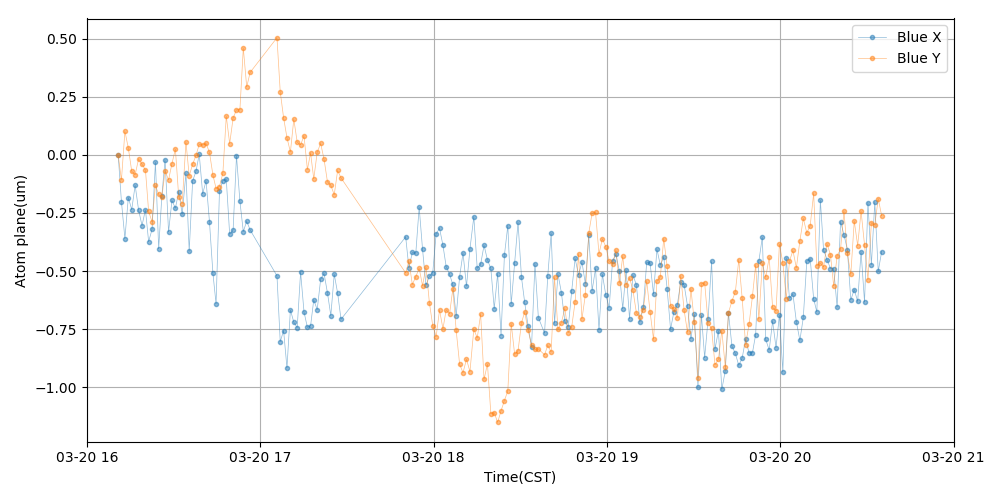

<IPython.core.display.Javascript object>


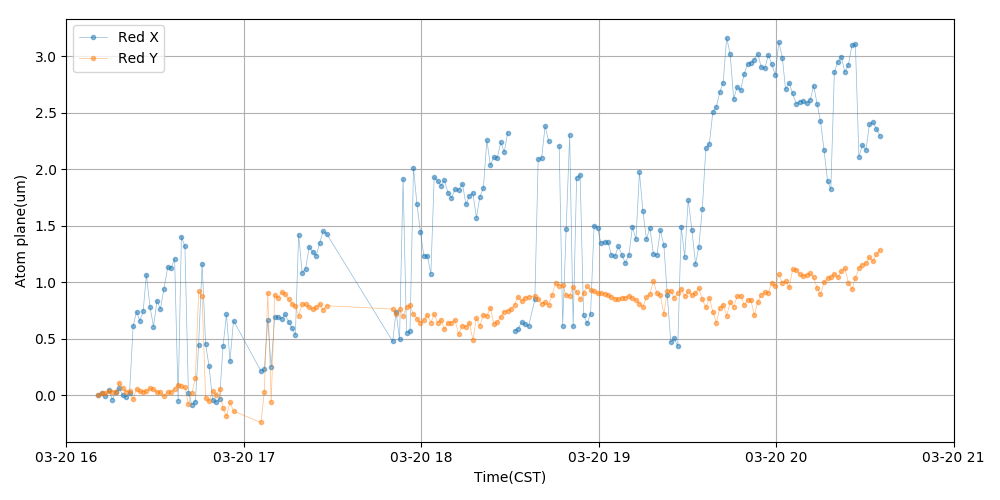

In [99]:
xfmt=md.DateFormatter('%D, %H:%M')
figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)

ax.plot(dates,blueX-blueX[0],lw=0.5,alpha=0.5, label='Blue X', marker='.')
ax.plot(dates,blueY-blueY[0],lw=0.5,alpha=0.5, label='Blue Y', marker='.')
ax.grid()
ax.legend()
ax.set_xlim('2018-03-20 16:00:00','2018-03-20 21:00:00')
ax.set_xlabel('Time(CST)')
ax.set_ylabel('Atom plane(um)')
plt.tight_layout()
plt.savefig('BlueAAS_openloop_stability.png',dpi=600)

figW=10
figH=5
fig, ax = plt.subplots()
fig.set_size_inches(figW,figH)

ax.plot(dates,(RedX-RedX[0]),lw=0.5,alpha=0.5, label='Red X', marker='.')
ax.plot(dates,(RedY-RedY[0]),lw=0.5,alpha=0.5, label='Red Y', marker='.')
ax.set_xlim('2018-03-20 16:00:00','2018-03-20 21:00:00')
ax.set_xlabel('Time(CST)')
ax.set_ylabel('Atom plane(um)')
ax.grid()
ax.legend()
plt.tight_layout()
plt.savefig('RedAAS_openloop_stability.png',dpi=600)
